In [1]:
import cv2
import numpy as np
import time
import mss
import mss.tools
from gymnasium import Env
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import pydirectinput
import pygetwindow as gw
import ctypes
import logging
import os
import gymnasium

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [3]:
logging.getLogger('ppocr').setLevel(logging.CRITICAL)

In [4]:


class FlappyBirdEnv(Env):
    def __init__(self,monitor_index=1):
        super().__init__()
        self.observation_space = spaces.Box(low=0, high=255, shape=(1,144,192) , dtype=np.uint8)
        self.action_space = spaces.Discrete(2)  # 0: No Jump, 1: Jump
        
        #self.step_count=1
        self.cnt=1
        self.cap = mss.mss()
        self.monitor = self.cap.monitors[monitor_index]
        self.roi = {'top': 150, 'left': 820, 'width': 960, 'height': 720}
        self.done_location = {'top':170, 'left':750, 'width':430, 'height':110}
        self.ocr = PaddleOCR(use_angle_cls=True, lang='en')
    
    def capture_screen(self):
        screenshot = self.cap.grab(self.roi)
        frame = np.array(screenshot)
        return frame
    
    def capture_done(self):
        screenshot = self.cap.grab(self.done_location)
        frame = np.array(screenshot)
        return frame

    def detect_contours(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return thresh, contours

    def reset(self, seed=None, return_info=False, options=None):
        super().reset(seed=seed)

        if self.cnt==1:
            game_window = gw.getWindowsWithTitle('Flappy Bird')[0]
            ctypes.windll.user32.SetForegroundWindow(game_window._hWnd)
            self.cnt = self.cnt+1
        
        info={}

        time.sleep(1.5)
        x, y = 970, 805
        # Move the mouse to the coordinates and click
        pydirectinput.moveTo(x, y)
        pydirectinput.click()
        #pydirectinput.press('space')
        return self.get_observation(),info
    
    def step(self, action):
        
            # Action key -> 0=noJummp , 1=Jump
        action_map = {
            0: 'no_jump',
            1: 'd'#jump
        }
        if action != 0:
            pydirectinput.press(action_map[action])

        truncated = False
        done , done_cap = self.get_done() # check if done
        new_observation =  self.get_observation() #get new observ
        #Reward
        reward = 1
        #Info dictionary
        info={}#.....streambaseline needs this
        
        return new_observation, reward, done, truncated, info

    def render(self):
        #plt.imshow('Game', np.array(self.get_observation()))
        pass

    def close(self):
        #cv2.destroyAllWindows()
        pass
    
    def get_observation(self):
        screen = self.capture_screen()
        gray = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        screen_resized = cv2.resize(gray, (192, 144))  # Resize to (58, 48)
        _, thresh = cv2.threshold(screen_resized, 160, 255, cv2.THRESH_BINARY_INV)  # Thresholding
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.ones_like(screen_resized) * 255  # Create mask
        cv2.drawContours(mask, contours, -1, (0), thickness=cv2.FILLED)  # Draw contours
        channel = np.expand_dims(mask, axis=0)  # Add channel dimension
        return channel



    def get_done(self):
        done_cap = self.capture_done() 
        target_bgr = [82, 159, 250]  # The BGR values you want to check
        target_coords_1 = (50, 50)   # Coordinate 1 for color check
        target_coords_2 = (350, 50)  # Coordinate 2 for color check
        time.sleep(0.1)
        pixel_value_1 = done_cap[target_coords_1[1], target_coords_1[0]]
        pixel_value_2 = done_cap[target_coords_2[1], target_coords_2[0]]
        
        done = all(pixel_value_1[:3] == target_bgr) and all(pixel_value_2[:3] == target_bgr)

        return done, done_cap






In [5]:
env = FlappyBirdEnv()

# observation


In [6]:
env.get_observation().shape

(1, 144, 192)

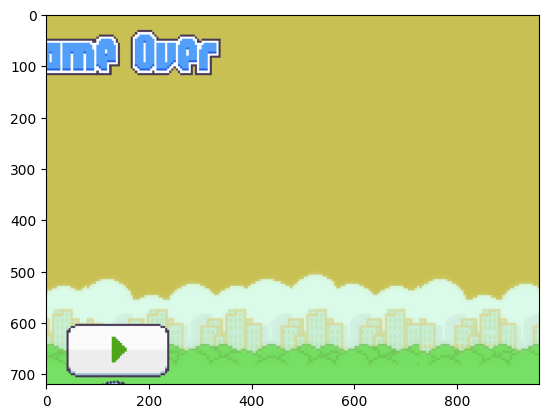

In [11]:
time.sleep(2)
plt.imshow(env.capture_screen())

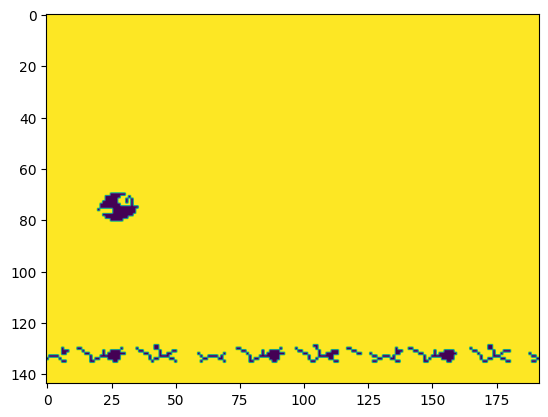

In [14]:
time.sleep(2)
plt.imshow(env.get_observation()[0])

# done screen


In [15]:
env = FlappyBirdEnv()

In [125]:
done_cap = env.capture_done()

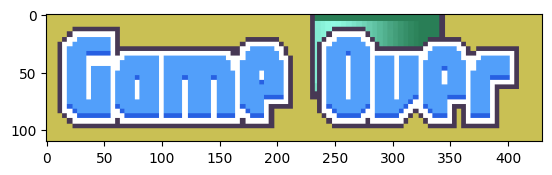

In [126]:
plt.imshow(done_cap)

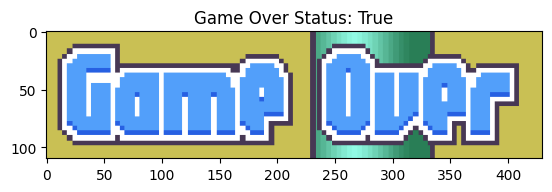

In [17]:
time.sleep(2)
done, done_cap = env.get_done()

# Check if done_cap is a valid image before displaying
if isinstance(done_cap, np.ndarray):  # assuming done_cap is a NumPy array
    plt.imshow(done_cap)
    plt.title(f"Game Over Status: {done}")
    plt.show()
else:
    print("Captured image is not valid.")


In [104]:
done_cap[50,350]

array([ 82, 159, 250, 255], dtype=uint8)

In [7]:
#time.sleep(2)
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done:  
        obs, reward,  done, truncated,info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode+1, total_reward))  

Total Reward for episode 1 is 9
Total Reward for episode 2 is 10
Total Reward for episode 3 is 10
Total Reward for episode 4 is 10
Total Reward for episode 5 is 10
Total Reward for episode 6 is 11
Total Reward for episode 7 is 11
Total Reward for episode 8 is 9
Total Reward for episode 9 is 8
Total Reward for episode 10 is 12


# Model


In [17]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA Available: True
CUDA Version: 11.8
Device Name: NVIDIA GeForce GTX 1650


In [20]:
!pip show gymnasium


Name: gymnasium
Version: 1.0.0a2
Summary: A standard API for reinforcement learning and a diverse set of reference environments (formerly Gym).
Home-page: 
Author: 
Author-email: Farama Foundation <contact@farama.org>
License: MIT License
Location: c:\users\dweep\appdata\local\programs\python\python310\lib\site-packages
Requires: cloudpickle, farama-notifications, numpy, typing-extensions
Required-by: Shimmy, stable_baselines3


In [38]:
!pip install --upgrade gymnasium stable-baselines3


  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0a2
    Uninstalling gymnasium-1.0.0a2:
      Successfully uninstalled gymnasium-1.0.0a2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shimmy 2.0.0 requires gymnasium>=1.0.0a1, but you have gymnasium 0.29.1 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from stable_baselines3.common.callbacks import BaseCallback

In [19]:

from stable_baselines3.common import env_checker

In [126]:
env_checker.check_env(env)

In [21]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True
    
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
 

In [22]:

callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [23]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack



In [127]:
env = FlappyBirdEnv()

In [129]:
model = DQN('CnnPolicy', env,device = 'cuda', tensorboard_log=LOG_DIR, verbose=1, buffer_size=60000, learning_starts=1500)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [135]:
model.load('train/best_model_31000') 

In [136]:

model.learn(total_timesteps=80000, callback=callback)

Logging to ./logs/DQN_4
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6        |
|    ep_rew_mean      | 6        |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 15       |
|    total_timesteps  | 24       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.25     |
|    ep_rew_mean      | 6.25     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 31       |
|    total_timesteps  | 50       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.5      |
|    ep_rew_mean      | 6.5      |
|    exploration_rate | 0.991    |
| time/               |        

KeyboardInterrupt: 

# Testingggg


In [131]:
model.load('train/best_model_31000') 

In [74]:
obs = env.reset()
obs[0].shape

(1, 48, 58)

In [76]:
obs = np.expand_dims(obs[0], axis=0)  # This adds a batch dimension, so shape becomes (1, 1, 48, 58)

# Predict the action
action, _ = model.predict(obs)

In [80]:
action

array(0, dtype=int64)

In [72]:
model.predict(obs[0])

(array(0, dtype=int64), None)

In [134]:
for episode in range(5): 
    obs = env.reset()
    obs = np.expand_dims(obs[0], axis=0)
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(int(action))
        #time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode+1, total_reward))
    #time.sleep(2)

Total Reward for episode 1 is 11
Total Reward for episode 2 is 7
Total Reward for episode 3 is 7
Total Reward for episode 4 is 8
Total Reward for episode 5 is 7
